In [0]:
%fs
ls /FileStore/tables/

path,name,size,modificationTime
dbfs:/FileStore/tables/NYPD_Complaint_Data_Historics.csv,NYPD_Complaint_Data_Historics.csv,631487933,1684144756000
dbfs:/FileStore/tables/US_Holiday_Dates.csv,US_Holiday_Dates.csv,15699,1683980008000


Importing all libraries

In [0]:
%pip install mlflow

Python interpreter will be restarted.
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143878 sha256=69bad30583a9640079e0355facb99b5351fe3daaa469aac78f72a5b7bca83800
  Stored in directory: /root/.cache/pip/wheels/b6/90/68/94d223a35a3910c1512a8d42d9f8333ce567ef26e250a56227
Successfully built databricks-cli
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-0d217dcb-707a-4952-a1db-0202c57cbffc
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-0d217dcb-707a-4952-a1db-0202c57cbffc
    Can't uninstall

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date 
from pyspark.sql.functions import year, month 
# Conver start date and end date to timestamp
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *
import os
from pyspark.ml.feature import StringIndexer, VectorAssembler, ChiSqSelector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

In [0]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

In [0]:
import mlflow
import mlflow.spark
import seaborn as sns

Dataset Loading from DBFS

In [0]:
df1 = spark.read.csv('/FileStore/tables/NYPD_Complaint_Data_Historics.csv',header=True, inferSchema=True)
df1.show(10)

+----------+------------+-------------------+------------+------------+-----------+----------+-----+--------------------+-----+--------------------+----------------+-----------+---------+-----------------+-------------------+----------------+-----------------+--------+----------+-----------+----------+----------+--------------+---------+--------+----------------+-----------------+------------------+--------------------+--------------------+------------+-------------+--------+-------+
|CMPLNT_NUM|CMPLNT_FR_DT|       CMPLNT_FR_TM|CMPLNT_TO_DT|CMPLNT_TO_TM|ADDR_PCT_CD|    RPT_DT|KY_CD|           OFNS_DESC|PD_CD|             PD_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|  BORO_NM|LOC_OF_OCCUR_DESC|      PREM_TYP_DESC|      JURIS_DESC|JURISDICTION_CODE|PARKS_NM|HADEVELOPT|HOUSING_PSA|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|TRANSIT_DISTRICT|         Latitude|         Longitude|             Lat_Lon|         PATROL_BORO|STATION_NAME|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+----------+----------

In [0]:
df1.count()

Out[5]: 1838507

In [0]:
df1.describe()

Out[6]: DataFrame[summary: string, CMPLNT_NUM: string, CMPLNT_TO_TM: string, ADDR_PCT_CD: string, KY_CD: string, OFNS_DESC: string, PD_CD: string, PD_DESC: string, CRM_ATPT_CPTD_CD: string, LAW_CAT_CD: string, BORO_NM: string, LOC_OF_OCCUR_DESC: string, PREM_TYP_DESC: string, JURIS_DESC: string, JURISDICTION_CODE: string, PARKS_NM: string, HADEVELOPT: string, HOUSING_PSA: string, X_COORD_CD: string, Y_COORD_CD: string, SUSP_AGE_GROUP: string, SUSP_RACE: string, SUSP_SEX: string, TRANSIT_DISTRICT: string, Latitude: string, Longitude: string, Lat_Lon: string, PATROL_BORO: string, STATION_NAME: string, VIC_AGE_GROUP: string, VIC_RACE: string, VIC_SEX: string]

In [0]:
df1.printSchema()

root
 |-- CMPLNT_NUM: string (nullable = true)
 |-- CMPLNT_FR_DT: date (nullable = true)
 |-- CMPLNT_FR_TM: timestamp (nullable = true)
 |-- CMPLNT_TO_DT: date (nullable = true)
 |-- CMPLNT_TO_TM: string (nullable = true)
 |-- ADDR_PCT_CD: integer (nullable = true)
 |-- RPT_DT: date (nullable = true)
 |-- KY_CD: integer (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- PD_CD: integer (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- CRM_ATPT_CPTD_CD: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- LOC_OF_OCCUR_DESC: string (nullable = true)
 |-- PREM_TYP_DESC: string (nullable = true)
 |-- JURIS_DESC: string (nullable = true)
 |-- JURISDICTION_CODE: integer (nullable = true)
 |-- PARKS_NM: string (nullable = true)
 |-- HADEVELOPT: string (nullable = true)
 |-- HOUSING_PSA: string (nullable = true)
 |-- X_COORD_CD: integer (nullable = true)
 |-- Y_COORD_CD: integer (nullable = true)
 |-- SUSP_AGE_GR

In [0]:
df1.columns

Out[8]: ['CMPLNT_NUM',
 'CMPLNT_FR_DT',
 'CMPLNT_FR_TM',
 'CMPLNT_TO_DT',
 'CMPLNT_TO_TM',
 'ADDR_PCT_CD',
 'RPT_DT',
 'KY_CD',
 'OFNS_DESC',
 'PD_CD',
 'PD_DESC',
 'CRM_ATPT_CPTD_CD',
 'LAW_CAT_CD',
 'BORO_NM',
 'LOC_OF_OCCUR_DESC',
 'PREM_TYP_DESC',
 'JURIS_DESC',
 'JURISDICTION_CODE',
 'PARKS_NM',
 'HADEVELOPT',
 'HOUSING_PSA',
 'X_COORD_CD',
 'Y_COORD_CD',
 'SUSP_AGE_GROUP',
 'SUSP_RACE',
 'SUSP_SEX',
 'TRANSIT_DISTRICT',
 'Latitude',
 'Longitude',
 'Lat_Lon',
 'PATROL_BORO',
 'STATION_NAME',
 'VIC_AGE_GROUP',
 'VIC_RACE',
 'VIC_SEX']

Data Cleaning & Preprocessing

In [0]:
df1 = df1.withColumn('Start_Date', to_timestamp('CMPLNT_FR_DT', 'MM/dd/yyyy'))
# Cast the data type to Date
df1 = df1.withColumn('Date', to_date('Start_Date'))
df1 = df1.withColumn('Hour', hour(df1['CMPLNT_FR_TM']))
# Create a new column of year number
df1 = df1.withColumn('YEAR', year('Date')) 
# Create a new column of month number
df1 = df1.withColumn('MONTH', month('Date'))
#Create a new column 'day_of_week' from 'date'
df1 = df1.withColumn("DoW", date_format("Date", "E"))

In [0]:
df1 = df1.withColumn('VIC_AGE_Cat',
    when(df1.VIC_AGE_GROUP == '<18', 'Teenager')
    .when(df1.VIC_AGE_GROUP == '18-25', 'Young Adult')
    .when(df1.VIC_AGE_GROUP == '25-44', 'Middle Age')
    .when(df1.VIC_AGE_GROUP == '44-64', 'Mid Old')
    .otherwise('Senior'))

In [0]:
df1 = df1.drop("PARKS_NM", "VIC_AGE_GROUP", "VIC_RACE", "STATION_NAME", "PATROL_BORO", "TRANSIT_DISTRICT", 
             "SUSP_SEX", "SUSP_RACE", "SUSP_AGE_GROUP", "X_COORD_CD", "Y_COORD_CD", "HOUSING_PSA", "HADEVELOPT", 
             "JURISDICTION_CODE", "JURIS_DESC", "JURIS_DESC", "RPT_DT", "JURIS_DESC", "PREM_TYP_DESC",
             "PD_CD", "PD_DESC", "CMPLNT_TO_TM", "CMPLNT_TO_DT", "CMPLNT_FR_DT", "LOC_OF_OCCUR_DESC", "CMPLNT_FR_TM","Start_Date")

In [0]:
df1.show(10)

+----------+-----------+-----+--------------------+----------------+-----------+---------+-----------------+------------------+--------------------+-------+----------+----+----+-----+---+-----------+
|CMPLNT_NUM|ADDR_PCT_CD|KY_CD|           OFNS_DESC|CRM_ATPT_CPTD_CD| LAW_CAT_CD|  BORO_NM|         Latitude|         Longitude|             Lat_Lon|VIC_SEX|      Date|Hour|YEAR|MONTH|DoW|VIC_AGE_Cat|
+----------+-----------+-----+--------------------+----------------+-----------+---------+-----------------+------------------+--------------------+-------+----------+----+----+-----+---+-----------+
| 770415824|          7|  117|     DANGEROUS DRUGS|       COMPLETED|     FELONY|MANHATTAN|40.71946627900007|-73.98193144799995|(40.7194662790000...|      E|2019-01-02|  20|2019|    1|Wed|     Senior|
| 330849037|         52|  341|       PETIT LARCENY|       COMPLETED|MISDEMEANOR|    BRONX|40.88175555600003|-73.88235556099994|(40.8817555560000...|      D|2019-01-02|  14|2019|    1|Wed|     Senior|


In [0]:
df1 = df1.toDF('Complaint_ID', 'Neighborhood', 'Offence_Code', 'Offence_Type',
        'Status','Offence_Level','Borough','Latitude','Longitude','Lat_Lon', 'Victim_Sex', 'Date', 'Hour', 'Year', 'Month', 'DoW','Victim_Agegroup')


In [0]:
mean_log = df1.agg({'Longitude': 'mean'}).collect()[0][0] 
df1 = df1.fillna(mean_log, subset=['Longitude'])

mean_lat = df1.agg({'Latitude': 'mean'}).collect()[0][0] 
df1 = df1.fillna(mean_lat, subset=['Latitude'])

df1 = df1.fillna(-1, subset=['Borough','Neighborhood','Offence_Code','Offence_Type','Status','Offence_level','Victim_Sex'])
df1 = df1.na.drop('any')

In [0]:
df1.show(10)

+------------+------------+------------+--------------------+---------+-------------+---------+-----------------+------------------+--------------------+----------+----------+----+----+-----+---+---------------+
|Complaint_ID|Neighborhood|Offence_Code|        Offence_Type|   Status|Offence_Level|  Borough|         Latitude|         Longitude|             Lat_Lon|Victim_Sex|      Date|Hour|Year|Month|DoW|Victim_Agegroup|
+------------+------------+------------+--------------------+---------+-------------+---------+-----------------+------------------+--------------------+----------+----------+----+----+-----+---+---------------+
|   770415824|           7|         117|     DANGEROUS DRUGS|COMPLETED|       FELONY|MANHATTAN|40.71946627900007|-73.98193144799995|(40.7194662790000...|         E|2019-01-02|  20|2019|    1|Wed|         Senior|
|   330849037|          52|         341|       PETIT LARCENY|COMPLETED|  MISDEMEANOR|    BRONX|40.88175555600003|-73.88235556099994|(40.8817555560000...

In [0]:
df = df1

In [0]:
df.show()

+------------+------------+------------+--------------------+---------+-------------+---------+------------------+------------------+--------------------+----------+----------+----+----+-----+---+---------------+
|Complaint_ID|Neighborhood|Offence_Code|        Offence_Type|   Status|Offence_Level|  Borough|          Latitude|         Longitude|             Lat_Lon|Victim_Sex|      Date|Hour|Year|Month|DoW|Victim_Agegroup|
+------------+------------+------------+--------------------+---------+-------------+---------+------------------+------------------+--------------------+----------+----------+----+----+-----+---+---------------+
|   770415824|           7|         117|     DANGEROUS DRUGS|COMPLETED|       FELONY|MANHATTAN| 40.71946627900007|-73.98193144799995|(40.7194662790000...|         E|2019-01-02|  20|2019|    1|Wed|         Senior|
|   330849037|          52|         341|       PETIT LARCENY|COMPLETED|  MISDEMEANOR|    BRONX| 40.88175555600003|-73.88235556099994|(40.88175555600

In [0]:
df = df.drop('Complaint_ID')

Exploratory Data Analysis

In [0]:
#creating database

spark.sql("drop database if exists nypddatabase cascade")
spark.sql("create database nypddatabase");
df.write.mode("overwrite").saveAsTable("nypddatabase.df")

In [0]:
display(spark.sql("select Borough,count(*) as Count from nypddatabase.df group by Borough order by Count desc limit 5"))

Borough,Count
BROOKLYN,520290
MANHATTAN,453453
BRONX,394454
QUEENS,390556
STATEN ISLAND,76737


Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql("select Offence_Level,count(*) as Count from nypddatabase.df group by Offence_Level"))

Offence_Level,Count
FELONY,595185
MISDEMEANOR,943705
VIOLATION,297575


Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql("select Offence_Level,Victim_Sex,count(*) as Count from nypddatabase.df group by Offence_Level,Victim_Sex"))

Offence_Level,Victim_Sex,Count
MISDEMEANOR,D,207978
MISDEMEANOR,M,309288
FELONY,M,235762
FELONY,D,86020
VIOLATION,D,2944
FELONY,F,204177
VIOLATION,F,187309
FELONY,E,67985
MISDEMEANOR,F,331937
MISDEMEANOR,E,94000


Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql("select Offence_Type,count(*) as Count from nypddatabase.df group by Offence_Type order by Count desc limit 10"))

Offence_Type,Count
PETIT LARCENY,371089
HARRASSMENT 2,294865
ASSAULT 3 & RELATED OFFENSES,199188
CRIMINAL MISCHIEF & RELATED OF,182394
GRAND LARCENY,168228
FELONY ASSAULT,89846
OFF. AGNST PUB ORD SENSBLTY &,70070
ROBBERY,57620
MISCELLANEOUS PENAL LAW,57131
BURGLARY,54616


Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql("select Offence_Level,Year,count(*) as Count from nypddatabase.df group by Offence_Level, Year"))

Offence_Level,Year,Count
VIOLATION,2021,75211
MISDEMEANOR,2021,223772
FELONY,2021,147867
VIOLATION,2020,67180
FELONY,2020,134051
MISDEMEANOR,2020,211467
MISDEMEANOR,2019,243794
FELONY,2019,140424
VIOLATION,2019,72113
FELONY,2022,172843


Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql("select Victim_Agegroup,count(*) as Count from nypddatabase.df group by Victim_Agegroup"))

Victim_Agegroup,Count
Senior,1099881
Teenager,63260
Middle Age,673324


Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql("select Year,count(*) as Count from nypddatabase.df group by Year"))

Year,Count
2020,412698
2021,446850
2019,456331
2022,520586


Databricks visualization. Run in Databricks to view.

In [0]:
display(spark.sql("select Month,count(*) as Count from nypddatabase.df group by Month"))

Month,Count
12,149374
1,144255
9,161261
8,164142
10,166127
11,156779
2,133296
6,157302
3,147442
5,155099


Databricks visualization. Run in Databricks to view.

Data Preprocessing

In [0]:
maxBins = 70
str_featues = []
num_features = []

for feature in df.dtypes:
    
    # print unique value and data type for each feature
    feature_name = str(feature[0])
    feature_type = str(feature[1])
    uni = df.select(feature_name).distinct().count()
    print("unique number of {} ({}):".format(feature_name, feature_type),uni)
    
    # find out features with integer type
    if feature_type == "int" or feature_type == "decimal(65,0)":
        
        num_features.append(feature_name)
        
    # find out string feature and it's unique value less than maxBins
    elif feature_type == "string" and uni < maxBins:
        
        str_featues.append(feature_name)
           

unique number of Neighborhood (int): 78
unique number of Offence_Code (int): 69
unique number of Offence_Type (string): 67
unique number of Status (string): 2
unique number of Offence_Level (string): 3
unique number of Borough (string): 6
unique number of Latitude (double): 159542
unique number of Longitude (double): 160045
unique number of Lat_Lon (string): 163800
unique number of Victim_Sex (string): 5
unique number of Date (date): 1460
unique number of Hour (int): 24
unique number of Year (int): 4
unique number of Month (int): 12
unique number of DoW (string): 7
unique number of Victim_Agegroup (string): 3


In [0]:
print("Total {} numerical features:{}".format(len(num_features),num_features)) 
print("Total {} string features:{}".format(len(str_featues),str_featues)) 

Total 5 numerical features:['Neighborhood', 'Offence_Code', 'Hour', 'Year', 'Month']
Total 7 string features:['Offence_Type', 'Status', 'Offence_Level', 'Borough', 'Victim_Sex', 'DoW', 'Victim_Agegroup']


In [0]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in str_featues]

In [0]:
index_names = ["{}_index".format(x) for x in str_featues] + num_features
assembler = VectorAssembler(inputCols= list(set(index_names) - set('Offence_Level_index')), outputCol="features")

In [0]:
pipeline = Pipeline(stages=indexers+[assembler])
data = pipeline.fit(df).transform(df)

In [0]:
# select feature col 
input_data = data.select(["features","Offence_Level_index"])
input_data = input_data.withColumnRenamed("Offence_Level_index","label")
# split dataset into train set and test set 
train_data, test_data = input_data.randomSplit([.8,.2])

Machine Learning

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', 
                                          metricName='accuracy')

In [0]:
def classification_report_pyspark(metrics_multiclass,preds_and_labels, labels_list):
    #import math
    columns = ['target_class', 'precision', 'recall', 'f1-score', 'support']

    data = []
    for i in labels_list:
        support = preds_and_labels.where('label = ' + str(i)).count()
        data.append((str(i), float(np.round(metrics_multiclass.precision(label = i),3)), 
                     float(np.round(metrics_multiclass.recall(label = i), 3)), 
                     float(np.round(metrics_multiclass.fMeasure(i), 3)), support)), 

    data.append(('weighted avg', float(np.round(metrics_multiclass.weightedPrecision, 3)), 
                                 float(np.round(metrics_multiclass.weightedRecall, 3)), 
                                   float(np.round(metrics_multiclass.weightedFMeasure(), 3)), preds_and_labels.count() ))
    class_rep = spark.createDataFrame(data, columns)
    return class_rep

Logistic Regression Model

In [0]:
lg_model = LogisticRegression(labelCol='label', maxIter=2, elasticNetParam=1, regParam=0.5,threshold=0.3)
lg_model = lg_model.fit(train_data)
lg_pred = lg_model.transform(test_data)
evaluator.evaluate(lg_pred)

Out[36]: 0.5123498969594181

In [0]:
lg_preds_and_labels = lg_pred.select(['prediction','label'])
lg_metrics = MulticlassMetrics(lg_preds_and_labels.rdd.map(tuple))
lg_metrics.confusionMatrix().toArray()

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Out[37]: array([[188202.,      0.,      0.],
       [119476.,      0.,      0.],
       [ 59653.,      0.,      0.]])

In [0]:
pd.DataFrame(lg_metrics.confusionMatrix().toArray())

,0,1,2
0,188202.0,0.0,0.0
1,119476.0,0.0,0.0
2,59653.0,0.0,0.0


Out[39]: <AxesSubplot:>

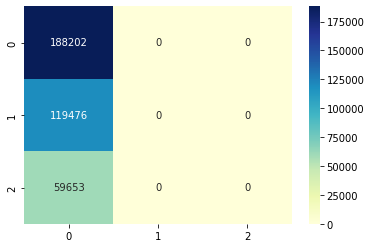

In [0]:
sns.heatmap(pd.DataFrame(lg_metrics.confusionMatrix().toArray()), annot=True, cmap="YlGnBu" ,fmt='g')

In [0]:
lg_class_rep = classification_report_pyspark(lg_metrics, lg_preds_and_labels, [0.0, 1.0, 2.0])
lg_class_rep.show()

+------------+---------+------+--------+-------+
|target_class|precision|recall|f1-score|support|
+------------+---------+------+--------+-------+
|         0.0|    0.512|   1.0|   0.678| 188202|
|         1.0|      0.0|   0.0|     0.0| 119476|
|         2.0|      0.0|   0.0|     0.0|  59653|
|weighted avg|    0.263| 0.512|   0.347| 367331|
+------------+---------+------+--------+-------+



Ensemble Model :- 
Random Forest Classifier

In [0]:
rf_model = RandomForestClassifier(labelCol='label',maxBins=75,numTrees=3,maxDepth=3)
rf_model = rf_model.fit(train_data)
rf_pred = rf_model.transform(test_data)
evaluator.evaluate(rf_pred)

Out[41]: 0.9991560744941211

In [0]:
rf_preds_and_labels = rf_pred.select(['prediction','label'])
rf_metrics = MulticlassMetrics(rf_preds_and_labels.rdd.map(tuple))
rf_metrics.confusionMatrix().toArray()

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Out[42]: array([[1.88202e+05, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 1.19476e+05, 0.00000e+00],
       [2.92000e+02, 1.80000e+01, 5.93430e+04]])

In [0]:
pd.DataFrame(rf_metrics.confusionMatrix().toArray())

,0,1,2
0,188202.0,0.0,0.0
1,0.0,119476.0,0.0
2,292.0,18.0,59343.0


Out[44]: <AxesSubplot:>

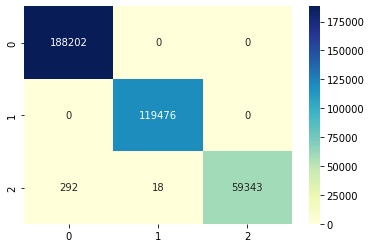

In [0]:
sns.heatmap(pd.DataFrame(rf_metrics.confusionMatrix().toArray()), annot=True, cmap="YlGnBu" ,fmt='g')

In [0]:
rf_class_rep = classification_report_pyspark(rf_metrics, rf_preds_and_labels, [0.0, 1.0, 2.0])
rf_class_rep.show()

+------------+---------+------+--------+-------+
|target_class|precision|recall|f1-score|support|
+------------+---------+------+--------+-------+
|         0.0|    0.998|   1.0|   0.999| 188202|
|         1.0|      1.0|   1.0|     1.0| 119476|
|         2.0|      1.0| 0.995|   0.997|  59653|
|weighted avg|    0.999| 0.999|   0.999| 367331|
+------------+---------+------+--------+-------+

